# Convolutional neural networks 101

Convolution neural networks are one of the most successful types of neural networks for image recognition and an integral part of reigniting the interest in neural networks. They are able to extract structural relations in the data, such as spatial in images or temporal in time series.

In this lab, we will experiment with inserting 2D-convolution layers in the fully connected neural networks introduced previously. We will also try to visualize the learned convolution filters and try to understand what kind of features they learn to recognize.

If you have not watched Jason Yosinski's [video on visualizing convolutional networks](https://www.youtube.com/watch?v=AgkfIQ4IGaM), you definitely should do so now. If you are unfamiliar with the convolution operation, [Vincent Dumoulin](https://github.com/vdumoulin/conv_arithmetic) has a nice visualization of different convolution variants. For a more in-depth tutorial, please see [cs231n.github.io/convolutional-networks](http://cs231n.github.io/convolutional-networks) or [neuralnetworksanddeeplearning.com/chap6.html](http://neuralnetworksanddeeplearning.com/chap6.html).

## Reminder: what are convolutional networks?

Standard ConvNets are, in many respects, very similar to the dense feedforward networks we saw previously:
 * The network is still organized into layers.
 * Each layer is parameterized by weights and biases.
 * Each layer has an element-wise non-linear transformation (activation function).
 * There are no cycles in the connections (more on this in later labs).

*So what is the difference?*
The networks we saw previously are called *dense* because each unit receives input from all the units in the previous layer. This is not the case for ConvNets. In ConvNets each unit is only connected to a small subset of the input units. This is called the *receptive field* of the unit.

#### Example
The input (green matrix) is a tensor of size `1x5x5`, i.e., it has one "channel" (like a grayscale image), and the feature map has size `5x5`. Let us define a `1x3x3` kernel (yellow submatrix). The kernel weights are indicated in red at the bottom right of each element. The computation can be thought of as an elementwise multiplication followed by a sum. Here we use a *stride* of 1, as shown in this animation:

<img src="https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/4_Convolutional/images/convolutions.gif" style="width: 400px;"/>

GIF courtesy of [Stanford](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution)

After having convolved the image, we perform an elementwise non-linear transformation on the *convolved features*.
In this example, the input is a 2D *feature map* with depth 1.


# Assignment 1

### Assignment 1.1: Manual calculations

Perform the following computation, and write the result below.

![](https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/4_Convolutional/images/conv_exe.png)

1. Manually convolve the input, and compute the convolved features. No padding and stride of 1.
 * **Answer:** \[\[ 6, 20\],\[ 14,25 \]\]
2. Perform `2x2` max pooling on the convolved features. Stride of 2.
 * **Answer:** 25

### Assignment 1.2: Output dimensionality

Given the following 3D tensor input `(channel, height, width)`, a given amount (`channels_out`) of filters `(channels_in, filter_height, filter_width)`, stride `(height, width)` and padding `(height, width)`, calculate the output dimensionality if it is valid.

1. input tensor with dimensionality (1, 28, 28) and 16 filters of size (1, 5, 5) with stride (1, 1) and padding (0, 0)
 * **Answer:** (16,24,24)
2. input tensor with dimensionality (2, 32, 32) and 24 filters of size (2, 3, 3) with stride (1, 1) and padding (0, 0)
 * **Answer:** (24,30,30)
3. input tensor with dimensionality (10, 32, 32) and 3 filters of size (10, 2, 2) with stride (2, 2) and padding (0, 0)
 * **Answer:** (3,16,16)
4. input tensor with dimensionality (11, 8, 16) and 7 filters of size (11, 3, 3) with stride (2, 2) and padding (1, 1)
 * **Answer:** invalid
5. input tensor with dimensionality (128, 256, 256) and 112 filters of size (128, 3, 3) with stride (1, 1) and padding (1, 1)
 * **Answer:** (112,256,256)


# Load packages

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import make_grid

sns.set_style("whitegrid")

# Load MNIST data

The code below downloads and loads the same MNIST dataset as before.
Note however that the data has a different shape this time: `(num_samples, num_channels, height, width)`.

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Load the MNIST dataset
train_dataset_full = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

# Create subsets: 50,000 for training, 10,000 for validation/testing
train_dataset = Subset(train_dataset_full, range(50000))
validation_dataset = Subset(train_dataset_full, range(50000, 60000))

# Get the number of classes
num_classes = train_dataset.dataset.targets.unique().size(0)

# Extract a batch from each dataset and print its shape
x_train, targets_train = next(iter(DataLoader(train_dataset, batch_size=64)))
x_valid, targets_valid = next(iter(DataLoader(validation_dataset, batch_size=64)))
x_test, targets_test = next(iter(DataLoader(test_dataset, batch_size=64)))

print("Information on dataset")
print("Shape of x_train:", x_train.shape)
print("Shape of targets_train:", targets_train.shape)
print("Shape of x_valid:", x_valid.shape)
print("Shape of targets_valid:", targets_valid.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of targets_test:", targets_test.shape)
print("Number of classes:", num_classes)

Information on dataset
Shape of x_train: torch.Size([64, 1, 28, 28])
Shape of targets_train: torch.Size([64])
Shape of x_valid: torch.Size([64, 1, 28, 28])
Shape of targets_valid: torch.Size([64])
Shape of x_test: torch.Size([64, 1, 28, 28])
Shape of targets_test: torch.Size([64])
Number of classes: 10


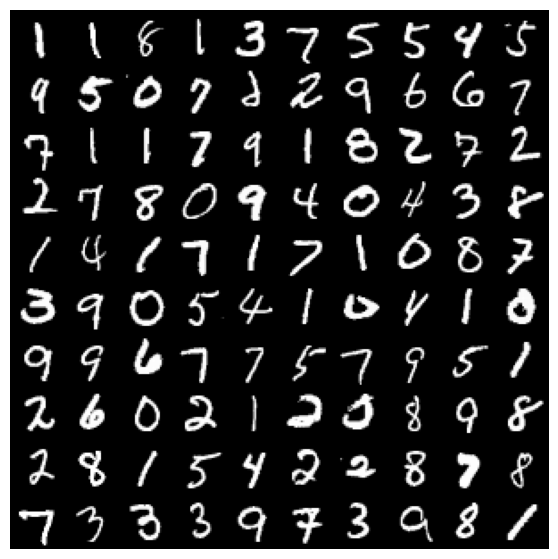

In [3]:
# Extract the 100 images from the training set
images, labels = next(iter(DataLoader(train_dataset, batch_size=100, shuffle=True)))

# Plot a few MNIST examples
plt.figure(figsize=(7, 7))
plt.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
plt.axis('off')
plt.show()

# Define a simple feed forward neural network

In [63]:
channels, height, width = x_train.shape[1:]
n_features = channels * height * width


class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first forward pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, stride=1, padding=2),
            activation_fn(),
            PrintSize(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=2),
            activation_fn(),
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=5, stride=1, padding=2),###Maybe add max pooling
            activation_fn(),
            nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
            nn.Linear(in_features=4*28*28, out_features=128),
            activation_fn(),
            nn.Linear(128, 128),
            activation_fn(),
            PrintSize(),
            nn.Linear(128, 128),
            activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


model = Model()
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): PrintSize()
    (3): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): Conv2d(16, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=3136, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): PrintSize()
    (11): Linear(in_features=128, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [64]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 1, 28, 28))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().numpy()}")

Size: torch.Size([2, 1, 28, 28])
Size: torch.Size([2, 32, 28, 28])
Size: torch.Size([2, 128])
Output shape: torch.Size([2, 10])
Output logits:
[[-0.12420735  0.00132772 -0.06381448 -0.04602814 -0.02147141 -0.03729138
  -0.07221343 -0.06499554  0.05469456 -0.04445679]
 [-0.11557472  0.01175135 -0.055918   -0.04941007 -0.02716056 -0.04684739
  -0.07771049 -0.0647544   0.04732144 -0.04446532]]
Output probabilities:
[[0.09199954 0.10430494 0.09772686 0.09948061 0.10195377 0.10035356
  0.0969095  0.09761151 0.11002257 0.09963706]
 [0.09284548 0.10545272 0.09855289 0.09919636 0.10142817 0.09945089
  0.09642841 0.09768587 0.10927119 0.09968807]]


# Train network

In [52]:
batch_size = 64
num_epochs = 5
validation_every_steps = 500

# Make data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
model.train()

train_accuracies = []
validation_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            validation_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in validation_loader:
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    validation_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            validation_accuracies.append(np.sum(validation_accuracies_batches) / len(validation_dataset))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {validation_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.94196875
             validation accuracy: 0.961
Step 1000    training accuracy: 0.9666095890410958
             validation accuracy: 0.9691
Step 1500    training accuracy: 0.96965625
             validation accuracy: 0.9682
Step 2000    training accuracy: 0.9771689497716894
             validation accuracy: 0.97
Step 2500    training accuracy: 0.9835788216560509
             validation accuracy: 0.9758
Step 3000    training accuracy: 0.97996875
             validation accuracy: 0.9768
Step 3500    training accuracy: 0.9849567819148937
             validation accuracy: 0.974
Finished training.


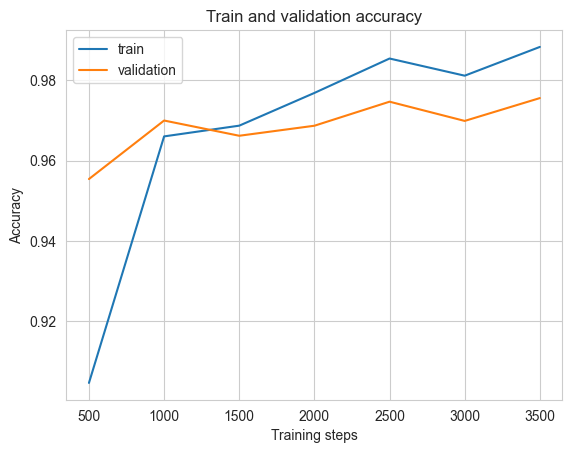

Validation accuracy: 0.976
Test accuracy: 0.974


In [48]:
steps = (np.arange(len(train_accuracies), dtype=int) + 1) * validation_every_steps

plt.figure()
plt.plot(steps, train_accuracies, label='train')
plt.plot(steps, validation_accuracies, label='validation')
plt.xlabel('Training steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Train and validation accuracy")
plt.show()

# Evaluate test set
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy_score(targets, predictions) * len(inputs))

    test_accuracy = np.sum(test_accuracies) / len(test_dataset)
    print(f"Validation accuracy: {validation_accuracies[-1]:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")
    
    model.train()
#     Step 500     training accuracy: 0.87875
#              validation accuracy: 0.9463
# Step 1000    training accuracy: 0.9529109589041096
#              validation accuracy: 0.958
# Step 1500    training accuracy: 0.9601875
#              validation accuracy: 0.9625
# Step 2000    training accuracy: 0.9699272260273972
#              validation accuracy: 0.9682
# Step 2500    training accuracy: 0.9776074840764332
#              validation accuracy: 0.9709
# Step 3000    training accuracy: 0.97734375
#              validation accuracy: 0.9748
# Step 3500    training accuracy: 0.9847490026595744
#              validation accuracy: 0.9741


### Assignment 2

1. Note the performance of the standard feedforward neural network. Add a [2D convolution layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) before the first layer. Insert the utility module `PrintSize` to check the size of the tensor at any point in `Sequential`, and notice that the size of the image reduces after the convolution. This can cause loss of information, and can be avoided by using adequate padding in the convolutional layer.
  Does adding a convolutional layer increase the generalization performance of the network (try num_filters=32 and filter_size=5 as a starting point)?
  

 Step 500     training accuracy: 0.87875\
              validation accuracy: 0.9463\
 Step 1000    training accuracy: 0.9529109589041096\
              validation accuracy: 0.958\
 Step 1500    training accuracy: 0.9601875\
              validation accuracy: 0.9625\
 Step 2000    training accuracy: 0.9699272260273972\
              validation accuracy: 0.9682\
 Step 2500    training accuracy: 0.9776074840764332\
              validation accuracy: 0.9709\
 Step 3000    training accuracy: 0.97734375\
              validation accuracy: 0.9748\
 Step 3500    training accuracy: 0.9847490026595744\
              validation accuracy: 0.9741\


2. Can the performance be increases even further by stacking more convolution layers?

Step 500     training accuracy: 0.94196875\
             validation accuracy: 0.961\
Step 1000    training accuracy: 0.9666095890410958\
             validation accuracy: 0.9691\
Step 1500    training accuracy: 0.96965625\
             validation accuracy: 0.9682\
Step 2000    training accuracy: 0.9771689497716894\
             validation accuracy: 0.97\
Step 2500    training accuracy: 0.9835788216560509\
             validation accuracy: 0.9758\
Step 3000    training accuracy: 0.97996875\
             validation accuracy: 0.9768\
Step 3500    training accuracy: 0.9849567819148937\
             validation accuracy: 0.974\
Finished training.\



3. We now have a deeper network than the initial simple feedforward network. What happens if we replace all convolutional layers with linear layers? Is this deep feedforward network performing as well as the convolutional one?
 


 
4. Max-pooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. In the classification algorithm which is usually desirable. You can either: 
 
   - add a maxpool layer (see the PyTorch docs, and try with kernel_size=2 and stride=2) after the convolution layer, or
   - add stride=2 to the arguments of the convolution layer directly.
     
  Verify that this decreases the spatial dimension of the image (insert a `PrintSize` module in the `Sequential`). Does this increase the performance of the network? Note that, to increase performance, you may need to stack multiple layers, increase the number of filters, or tune the learning rate.

5. Dropout is a very useful technique for preventing overfitting. Try to add a DropoutLayer after some of the convolution layers. You may observe a higher validation accuracy but lower train accuracy. Can you explain why this might be the case?
 
6. Batch normalization may help convergence in larger networks as well as generalization performance. Try to insert batch normalization layers into the network.


Again, if you didn't already, you really should [watch this video](https://www.youtube.com/watch?v=AgkfIQ4IGaM).